Den sista versionen för att skapa och träna en modell. Har inte testat om det funkar i övrigt.

## Steg 1 - Installera och förbered För den äldre varianten av Tensorflow

Se anmärkning på rad 7

In [2]:
# @title Lösning: Flera textfiler + Grafer + Legacy Keras
import os

# 1. INSTALLERA TENSORFLOWJS
# AXELS ANMÄRKNING. Efter första körningen kan du dektivera installen genom att
# sätta ett # först på rad 7. Men GLÖM INTE DET SEN
!pip install tensorflowjs

# 2. TVINGA KERAS 2 (Legacy Mode - VIKTIGT FÖR ATT UNDVIKA FEL)
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_KERAS"] = "1"

import tensorflow as tf
import tensorflowjs as tfjs
import numpy as np
import pandas as pd
import json
import shutil
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import files

print(f"TensorFlow version: {tf.__version__}")
print()

TensorFlow version: 2.19.0



I denna lösning skall du kunna göra alternativa val den data du tränar på.
I detta steg använder du bara de meningar som finna inlagda, som kopieras ett antal gånger. Modellen blir klart övertränad

In [ ]:
# @title Lösning: Flera textfiler + Grafer + Legacy Keras
import os

# 1. INSTALLERA TENSORFLOWJS
!pip install tensorflowjs

# 2. TVINGA KERAS 2 (Legacy Mode - VIKTIGT FÖR ATT UNDVIKA FEL)
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_KERAS"] = "1"

import tensorflow as tf
import tensorflowjs as tfjs
import numpy as np
import pandas as pd
import json
import shutil
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import files

print(f"TensorFlow version: {tf.__version__}")

# --- STEG A: SKAPA DINA TEXTFILER ---
# Här simulerar vi att du har två olika filer.
# I verkligheten kan du ladda upp dessa via menyn till vänster istället.

# INNEHÅLL I FIL 1 (Grunddatan)
file_content_1 = """
Scenerna var varken bra eller dåliga, mest helt okej	neutral
En otroligt mäktig helhet som verkligen lämnade ett avtryck	positiv
Vilket fantastiskt och djupt berörande slut på filmen	positiv
Slutet kändes ganska intetsägande och gav inget extra	neutral
Manuset var riktigt bra skrivet och fotot var vackert	positiv
Handlingen kändes mest fjantig och filmen var alldeles för lång	negativ
En onödigt rörig idé som aldrig riktigt lyfte	negativ
Dialogen var tight och skådespelarna gjorde ett fantastiskt jobb	positiv
Stämningen gjorde mig nästan besviken, den kändes platt	negativ
Musiken var smart vald och passade helt underbart till bilderna	positiv
Filmen var seg och kändes otroligt lång att ta sig igenom	negativ
Tempot var lagom, varken för snabbt eller för långsamt	neutral
"""

# INNEHÅLL I FIL 2 (Extra data som du vill lägga till)
file_content_2 = """
Jag somnade nästan för att den var så otroligt tråkig	negativ
En helt ny nivå av filmskapande, jag är stum av beundran	positiv
Det var en okej rulle att se en regnig söndag men inget mer	neutral
Karaktärerna kändes platta och jag brydde mig inte om dem	negativ
Vilken kemi mellan skådespelarna, det slog gnistor om dem	positiv
Effekterna var bedrövliga och såg ut som ett datorspel	negativ
Helt klart en av årets bästa filmupplevelser för mig	positiv
Den var lite väl pretentiös för min smak faktiskt	negativ
Ganska mysig film som man blir glad av att se	positiv
Inget jag kommer minnas om en vecka, ganska blek	neutral
"""

# Vi sparar dessa som riktiga filer på disken i Colab
with open('dataset_part1.txt', 'w', encoding='utf-8') as f:
    f.write(file_content_1.strip())

with open('dataset_part2.txt', 'w', encoding='utf-8') as f:
    f.write(file_content_2.strip())

print("✅ Filer skapade: 'dataset_part1.txt' och 'dataset_part2.txt'")



Om du även vill läsa in och träna på en fil kallad dataset3.txt som du kan hämta från Vklass, och ladda upp filer, så kan du göra det. Körningen kommer INTE att krascha om filen inte är uppladdad. På rad 42 kan du ändra på faktorn som meningarna kopieras upp med.

In [5]:

# --- STEG B: LÄS IN FLERA FILER ---

# Lista på alla filer du vill läsa in.
# Vill du ha en tredje fil? Lägg bara till 'filnamn.txt' i listan!
# AXELS Anmärkning!
# Om du har laddat upp filen i filse kallad dataset3.txt ingår den också i träningen

files_to_read = ['dataset_part1.txt', 'dataset_part2.txt','/content/dataset3.txt']

all_sentences = []
all_labels = []

print(f"\nLäser in filer: {files_to_read}...")

for filename in files_to_read:
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            line_count = 0
            for line in f:
                line = line.strip()
                if not line: continue

                # Dela upp raden (sista ordet är label)
                parts = line.split()
                if len(parts) < 2: continue # Hoppa över om raden är för kort

                label = parts[-1]
                sentence = " ".join(parts[:-1])

                all_sentences.append(sentence)
                all_labels.append(label)
                line_count += 1
            print(f"   -> Läste in {line_count} meningar från {filename}")

    except FileNotFoundError:
        print(f"   ❌ VARNING: Kunde inte hitta filen {filename}")

# --- STEG C: DATA AUGMENTATION (För grafernas skull) ---
# Vi multiplicerar all insamlad data för att få modellen att träna hårdare

multiplication_factor = 20
sentences = all_sentences * multiplication_factor
labels = all_labels * multiplication_factor

print(f"\nTotal datamängd efter duplicering: {len(sentences)} meningar")
print()


Läser in filer: ['dataset_part1.txt', 'dataset_part2.txt', '/content/dataset3.txt']...
   -> Läste in 12 meningar från dataset_part1.txt
   -> Läste in 10 meningar från dataset_part2.txt
   -> Läste in 600 meningar från /content/dataset3.txt

Total datamängd efter duplicering: 12440 meningar



Nu är all data inläst och förberedd. har du även lagt till filen dataset3.txt så är det 12440 meningar den tränar på. Men det är många dubletter, och inte så många unika värden. Modellen kommer att bli övertränad. Men det är problemet när vi arbetar med "tillverkad" data. Men själva modellen kommer att fungera på "äkta" data. /Axels anm På rad 30 kan du ändra antalet epoker. Lite mindre intressant på den data vi har.

In [8]:
# --- STEG D: FÖRBEREDELSER för träning och träning
label_df = pd.get_dummies(labels)
y = label_df.values
label_map = list(label_df.columns)

vocab_size = 1000
embedding_dim = 16
max_length = 20
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# --- STEG E: BYGG MODELL & TRÄNA ---
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nStartar träning...")
history = model.fit(padded, y, epochs=50, verbose=0) # Här kan du ändra antalet epoker
print("Träning klar.")


Startar träning...
Träning klar.


Visa utfallet av träningen. Accuracy och Loss. För förståelse. Ta ett skärmklipp av graferna och klistra in i en gpt. Använd dig av prompten. "Agera som en expert på Machine Learning. Förklara på en nivå anpassad för en gymnasieelev hur dessa två grafer kan tolkas. Hur kan modellen beskrivas?"

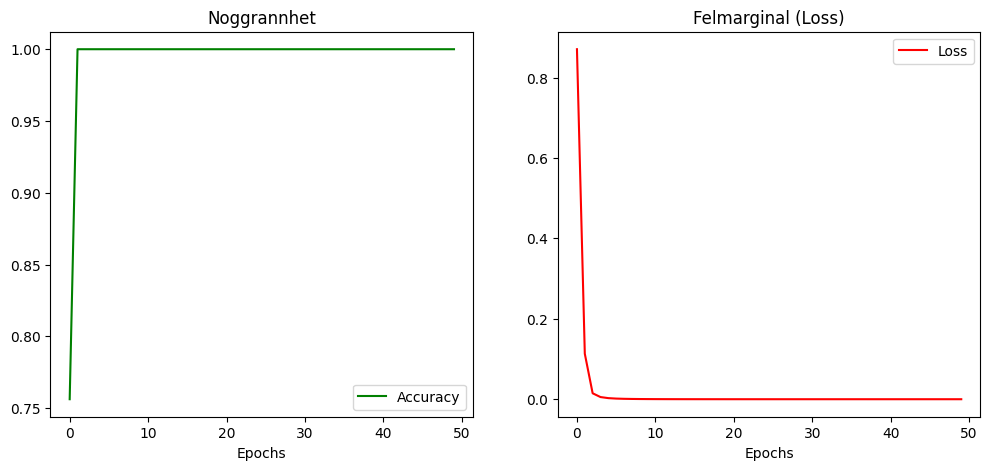

In [7]:
# --- STEG F: RITA GRAFER ---
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy', color='green')
plt.title('Noggrannhet')
plt.xlabel('Epochs')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss', color='red')
plt.title('Felmarginal (Loss)')
plt.xlabel('Epochs')
plt.legend()

plt.show()
print()

Spara modellerna i ett zippat arkiv. När du har packat upp dem, så är det tre filerna du skall ladda upp, så att modellen kan använda sig av dem. Spara i din onedrive och packa upp. Ladda sedan upp på GitHub. PS. De läggs också i din mapp för hämtade filer på datorn. Var? Beror på den webbläsare du använder.

In [10]:
# --- STEG G: SPARA ---
output_dir = 'tfjs_model_multi_files'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

tfjs.converters.save_keras_model(model, output_dir)

metadata = {
    'word_index': word_index,
    'max_length': max_length,
    'padding_type': padding_type,
    'trunc_type': trunc_type,
    'labels': label_map,
    'oov_token': oov_tok
}
with open(os.path.join(output_dir, 'metadata.json'), 'w', encoding='utf-8') as f:
    json.dump(metadata, f)

zip_filename = 'tfjs_multi_files.zip'
!zip -r {zip_filename} {output_dir}

print(f"\n✅ KLAR. Laddar ner '{zip_filename}'.")
files.download(zip_filename)
print()

updating: tfjs_model_multi_files/ (stored 0%)
updating: tfjs_model_multi_files/metadata.json (deflated 57%)
updating: tfjs_model_multi_files/group1-shard1of1.bin (deflated 7%)
updating: tfjs_model_multi_files/model.json (deflated 71%)

✅ KLAR. Laddar ner 'tfjs_multi_files.zip'.


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TensorFlow version: 2.19.0
✅ Filer skapade: 'dataset_part1.txt' och 'dataset_part2.txt'

Läser in filer: ['dataset_part1.txt', 'dataset_part2.txt', '/content/dataset3.txt']...
   -> Läste in 12 meningar från dataset_part1.txt
   -> Läste in 10 meningar från dataset_part2.txt
   ❌ VARNING: Kunde inte hitta filen /content/dataset3.txt

Total datamängd efter duplicering: 440 meningar

Startar träning...
Träning klar.


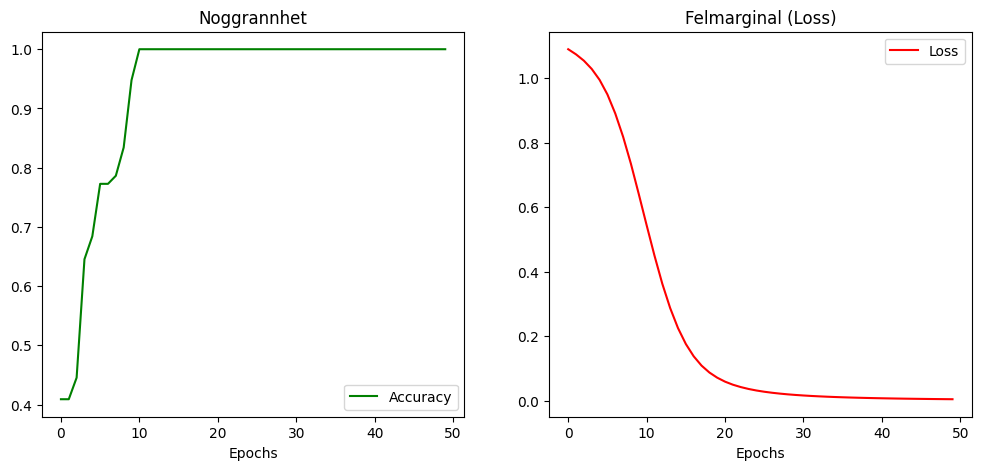

14/14 [==============================] - 0s 3ms/step


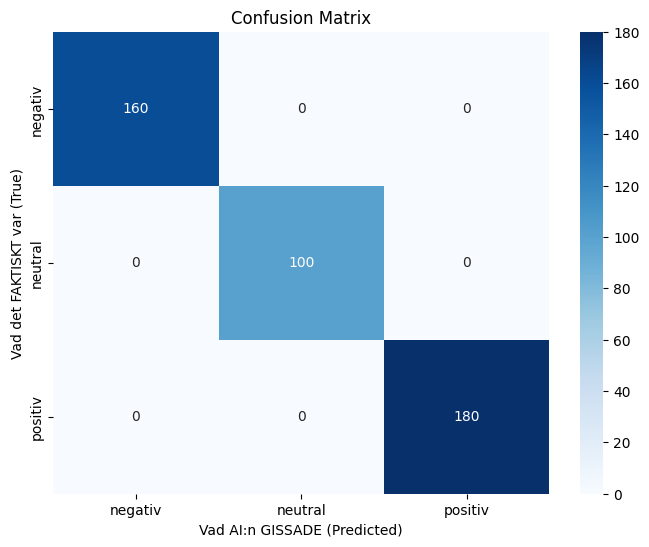

  adding: tfjs_model_multi_files/ (stored 0%)
  adding: tfjs_model_multi_files/metadata.json (deflated 54%)
  adding: tfjs_model_multi_files/group1-shard1of1.bin (deflated 8%)
  adding: tfjs_model_multi_files/model.json (deflated 71%)

✅ KLAR. Laddar ner 'tfjs_multi_files.zip'.


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:


# --- STEG F: RITA GRAFER ---
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy', color='green')
plt.title('Noggrannhet')
plt.xlabel('Epochs')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss', color='red')
plt.title('Felmarginal (Loss)')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# Axel tillagd Confusion Matrix
# @title Visa Confusion Matrix (Var gör AI:n fel?)
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Låt modellen gissa på all data igen
predictions = model.predict(padded)

# 2. Översätt från "sannolikheter" till "klass-nummer" (0, 1, 2)
# np.argmax tar reda på vilken stapel som är högst
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y, axis=1)

# 3. Skapa matrisen
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 4. Rita upp den snyggt med Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map,
            yticklabels=label_map)

plt.xlabel('Vad AI:n GISSADE (Predicted)')
plt.ylabel('Vad det FAKTISKT var (True)')
plt.title('Confusion Matrix')
plt.show()





# --- STEG G: SPARA ---
output_dir = 'tfjs_model_multi_files'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

tfjs.converters.save_keras_model(model, output_dir)

metadata = {
    'word_index': word_index,
    'max_length': max_length,
    'padding_type': padding_type,
    'trunc_type': trunc_type,
    'labels': label_map,
    'oov_token': oov_tok
}
with open(os.path.join(output_dir, 'metadata.json'), 'w', encoding='utf-8') as f:
    json.dump(metadata, f)

zip_filename = 'tfjs_multi_files.zip'
!zip -r {zip_filename} {output_dir}

print(f"\n✅ KLAR. Laddar ner '{zip_filename}'.")
files.download(zip_filename)